In [37]:
import pandas as pd
import seaborn as sns
from pylab import *
%matplotlib inline

#Read table 

In [38]:
usecols = ["Mutationid", "Refseq", "Genesymbol", "miRNA",
           "Targetsiteclass", "Cancertype", "Targetscan", "wildtype_csp", "mutant_csp",
           "pita_ref", "pita_mut"]
df = pd.read_table("target_somatic.txt.gz", compression='gzip', usecols=usecols)
print df.shape

(565953, 11)


In [39]:
genes = sorted(set(df["Genesymbol"].values))[1:]  # exclude nan
miRs = sorted(set(df["miRNA"].values))[1:]  # exclude nan
print "Total", len(miRs), "miRNAs"
print "Total", len(genes), "genes"

Total 1921 miRNAs
Total 8375 genes


#Select prediction method: TargetScan or Pita

In [40]:
#prefix = 'pita'
prefix = 'targetscan'

In [41]:
if prefix == "pita":
    df = df.dropna(subset=["pita_ref", "pita_mut"])
    df["diff"] = df["pita_ref"] - df["pita_mut"]
elif prefix == "targetscan":
    df = df[df["Targetscan"] == 1]
    df.replace("no TS", 0, inplace=True)
    df.fillna(0, inplace=True)
    df["diff"] = df["wildtype_csp"].astype(float) - df["mutant_csp"].astype(float)
else:
    print "Unsupported method!"
print df.shape

(113691, 12)


#Main

Prepare output in-/out-degree dataframes.

In [42]:
indeg_df = pd.DataFrame(index=genes)
outdeg_df = pd.DataFrame(index=miRs)
print indeg_df.shape
print outdeg_df.shape

(8375, 0)
(1921, 0)


Pivot the mutation table to compute the in-/out-degree tables.

In [43]:
for cancer in set(df["Cancertype"].values):
    test = df[df["Cancertype"] == cancer]
    #if "TCGA" in cancer:
    #    continue
    if test.shape[0] < 500:  # filter out those cancer types with too few rewiring events
        continue
    print cancer, test.shape
    t1 = test.pivot_table(index=["Genesymbol", "Mutationid"], columns="miRNA", values="diff").fillna(0)
    t2 = t1.groupby(level="Genesymbol").sum()
    outdeg_df[cancer] = t2.sum(axis=0)
    indeg_df[cancer] = t2.sum(axis=1)

BreastCarcinoma(WTSI,UK) (800, 12)
Melanoma (1330, 12)
Leukemia/T-ALL (685, 12)
BladderUrothelialCarcinoma(TCGA,US) (714, 12)
GastricCancer(CCGC,CN) (1238, 12)
Colorectal adenocarcinoma (3728, 12)
LiverCancer(NCC,JP) (28048, 12)
Small cell lung cancer (541, 12)
Breast Cancer (2328, 12)
RectumAdenocarcinoma(TCGA,US) (647, 12)
Medulloblastoma (1517, 12)
Hypodiploid_ALL (1124, 12)
Prostate (934, 12)
ColonAdenocarcinoma(TCGA,US) (3420, 12)
LiverCancer(RIKEN,JP) (24157, 12)
Lung (2141, 12)
UterineCorpusEndometrioidCarcinoma(TCGA,US) (7796, 12)
ProstateCancer(OICR,CA) (29327, 12)


Fillna & zscore

In [44]:
indeg_df.fillna(0, inplace=True)
outdeg_df.fillna(0, inplace=True)

In [45]:
from scipy.stats import zscore
t1 = indeg_df.apply(zscore)
t2 = outdeg_df.apply(zscore)

Output the tables

In [46]:
t1.to_csv("%s_indeg_zscore.tsv" % prefix, sep="\t")
t2.to_csv("%s_outdeg_zscore.tsv" % prefix, sep="\t")

Plot the heatmaps

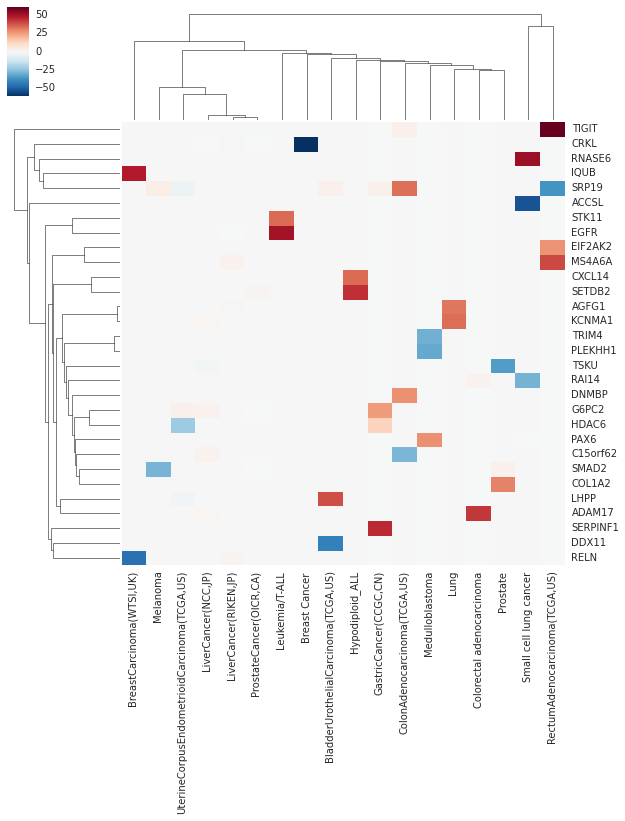

In [47]:
foo = t1.loc[t1.var(axis=1).sort(inplace=False)[-30:].index]
sns.clustermap(foo)
savefig("%s_indeg_zscore.heatmap.png" % prefix, dpi=300)

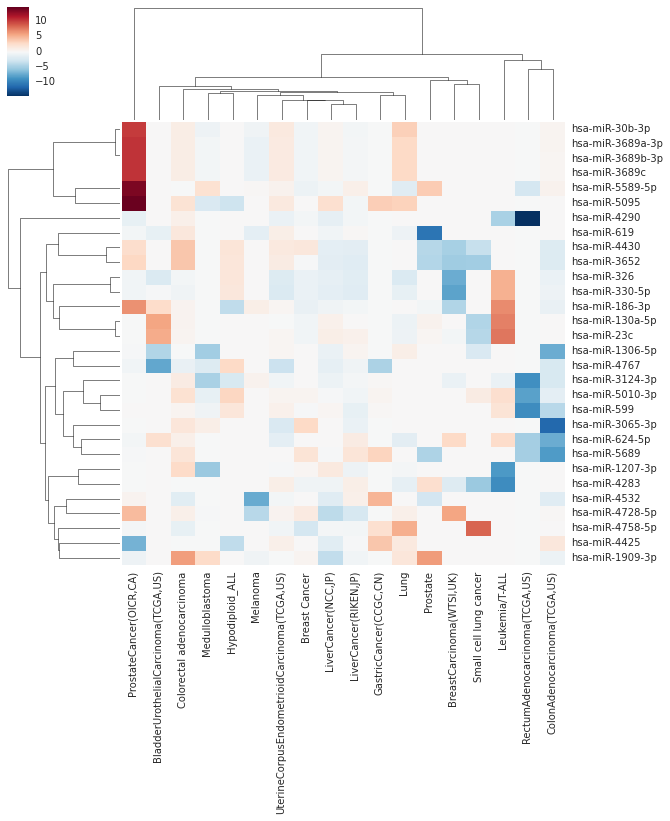

In [48]:
bar = t2.loc[t2.var(axis=1).sort(inplace=False)[-30:].index]
sns.clustermap(bar)
savefig("%s_outdeg_zscore.heatmap.png" % prefix, dpi=300)